In [155]:
#Libraries
import numpy as np 
import pandas as pd 
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import date
import pandas_datareader as data
from pandas_datareader import *
import math
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [156]:
#Scraping Dataset from Yahoo Finance using yfinance
#Getting data for the Apple Stock
aapl = yf.Ticker("AAPL")

# Apple Company Information
# aapl.info

# Apple's Historical Stock Prices (10 Year Period)
aapl.dataset = aapl.history(period="10y")

aapl.dataset.tail(10)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-04-11,168.710007,169.029999,165.500000,165.750000,72246700,0.0,0.0
2022-04-12,168.020004,169.869995,166.639999,167.660004,79265200,0.0,0.0
2022-04-13,167.389999,171.039993,166.770004,170.399994,70618900,0.0,0.0
2022-04-14,170.619995,171.270004,165.039993,165.289993,75237500,0.0,0.0
2022-04-18,163.919998,166.600006,163.570007,165.070007,69023900,0.0,0.0
2022-04-19,165.020004,167.820007,163.910004,167.399994,67723800,0.0,0.0
2022-04-20,168.759995,168.880005,166.100006,167.229996,67929800,0.0,0.0
2022-04-21,168.910004,171.529999,165.910004,166.419998,87227800,0.0,0.0
2022-04-22,166.460007,167.869995,161.500000,161.789993,84775200,0.0,0.0


In [157]:
#Dataframe basic information on rows and columns
aapl.dataset.shape

(2516, 7)

In [158]:
#Dropped Columns 'Dividends' and 'Stock Splits'
aapl.dataset.drop(['Dividends', 'Stock Splits'], axis=1)

,Open,High,Low,Close,Volume
Date,,,,,
2012-04-26,18.785125,18.797971,18.413870,18.584208,536068400
2012-04-27,18.503777,18.537721,18.364019,18.440472,406722400
2012-04-30,18.281453,18.299802,17.828850,17.858820,506144800
2012-05-01,17.886956,18.249649,17.774723,17.802246,610999200
2012-05-02,17.744445,17.963407,17.702243,17.919981,427389200
...,...,...,...,...,...
2022-04-19,165.020004,167.820007,163.910004,167.399994,67723800
2022-04-20,168.759995,168.880005,166.100006,167.229996,67929800
2022-04-21,168.910004,171.529999,165.910004,166.419998,87227800


In [159]:
#YFinance Bug- Dropped columns appears after being dropped so copying into new dataset
dataset = aapl.dataset [['Open', 'Close', 'High', 'Low','Volume']].copy()
dataset.tail()

,Open,Close,High,Low,Volume
Date,,,,,
2022-04-19,165.020004,167.399994,167.820007,163.910004,67723800
2022-04-20,168.759995,167.229996,168.880005,166.100006,67929800
2022-04-21,168.910004,166.419998,171.529999,165.910004,87227800
2022-04-22,166.460007,161.789993,167.869995,161.500000,84775200
2022-04-25,161.119995,162.880005,163.169998,158.460007,92824080


ADDING TECHNICAL INDICATORS TO DATASET

Stochastic Oscillator Indicator

In [160]:
# Calculating %K and %D
dataset['14-high'] = dataset['High'].rolling(14).max()
dataset['14-low'] = dataset['Low'].rolling(14).min()
dataset['%K'] = (dataset['Close'] - dataset['14-low'])*100/(dataset['14-high'] - dataset['14-low'])
dataset['%D'] = dataset['%K'].rolling(3).mean()


In [161]:
#Dropping 14-HIGH AND 14-LOW COLUMNS
dataset.drop(['14-high', '14-low'], axis = 1, inplace=True)

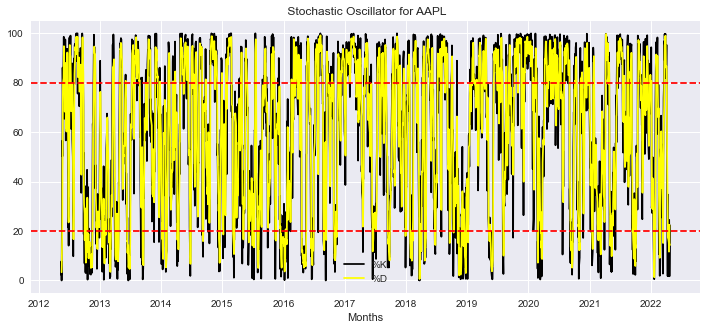

In [162]:
#Plotting SO Graph
plt.figure(figsize=(12, 5))
plt.title(' Stochastic Oscillator for AAPL')
plt.xlabel('Months')
plt.plot(dataset['%K'], label='%K', c='black')
plt.plot(dataset['%D'], label='%D',  c='yellow')
plt.axhline(20, linestyle='--', color="r")
plt.axhline(80, linestyle="--", color="r")
plt.legend()
plt.show()


In [163]:
# Adding Buy/Sell Signals from Sotchastic Oscillator Indicator
def categorise_so(row):  
    if row['%K'] <= 20 and row['%D'] <= 20:
        return 'Buy'
    elif row['%K'] >= 80 and  row['%D']>= 80:
        return 'Sell'
    else:
        return 'Hold'

    
   
dataset['SO Indicator'] = dataset.apply(lambda row: categorise_so(row), axis=1)


In [164]:
# Distrubition of the Indicator
print(dataset['SO Indicator'].value_counts())

Hold    1552
Sell     725
Buy      239
Name: SO Indicator, dtype: int64


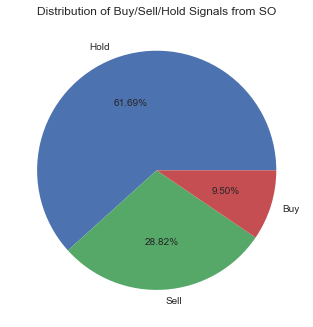

In [165]:
#Distrubition of the SO Indicator
labels = ["Hold", "Sell", "Buy"]
values = dataset['SO Indicator'].value_counts().tolist()
plt.style.use("seaborn")
plt.pie(x=values, labels=labels, autopct="%1.2f%%")
plt.title("Distribution of Buy/Sell/Hold Signals from SO")
plt.show()

Relative Strength Index

In [166]:
delta = dataset['Close'].diff()
up = delta.clip(lower=0)
down = -1*delta.clip(upper=0)
ema_up = up.ewm(com=13, adjust=False).mean()
ema_down = down.ewm(com=13, adjust=False).mean()
rs = ema_up/ema_down
dataset['RSI'] = 100 - (100/(1 + rs))

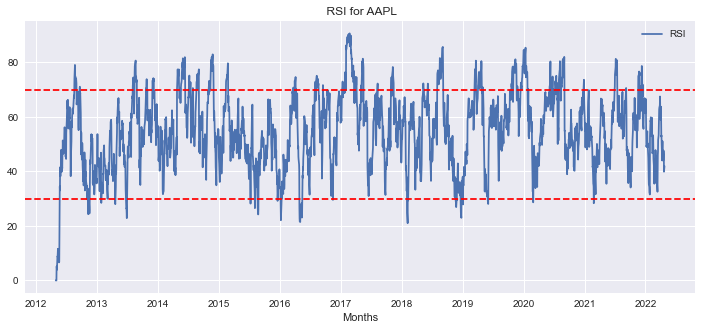

In [167]:
#Plotting RSI Graph
plt.figure(figsize=(12, 5))
plt.title(' RSI for AAPL')
plt.xlabel('Months')
plt.plot(dataset['RSI'], label='RSI')
plt.axhline(30, linestyle='--', color="r")
plt.axhline(70, linestyle="--", color="r")
plt.legend()
plt.show()



In [168]:
# Adding Buy/Sell Signals from RSI Indicator
def categorise_rsi(row):  
    if row['RSI'] <= 30:
        return 'Buy'
    elif row['RSI'] >= 70:
        return 'Sell'
    else:
        return 'Hold'
  
dataset['RSI Indicator'] = dataset.apply(lambda row: categorise_rsi(row), axis=1)

In [169]:
# Distrubition of the Indicator
print(dataset['RSI Indicator'].value_counts())

Hold    2076
Sell     362
Buy       78
Name: RSI Indicator, dtype: int64


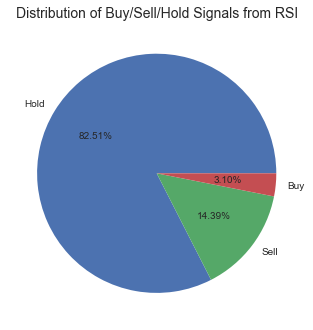

In [170]:
#Distrubition of the Indicator
labels = ["Hold", "Sell", "Buy"]
values = dataset['RSI Indicator'].value_counts().tolist()
plt.style.use("seaborn")
plt.pie(x=values, labels=labels, autopct="%1.2f%%")
plt.title("Distribution of Buy/Sell/Hold Signals from RSI", fontdict={'fontsize': 14})
plt.show()

Bollinger Bands

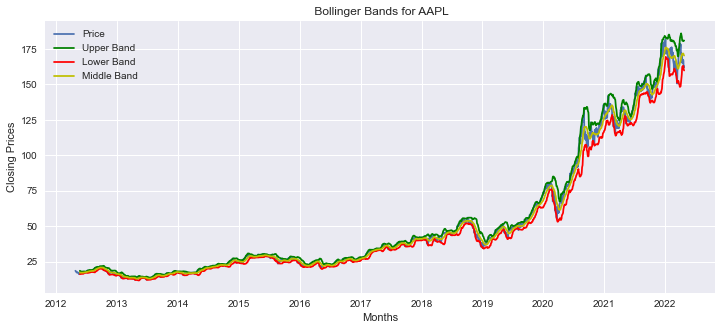

In [171]:
def get_sma(prices, rate):
    return prices.rolling(rate).mean()

def get_bollinger_bands(prices, rate=20):
    # SMA for 20 Days (Middle Band)
    sma = get_sma(prices, rate)
    std = prices.rolling(rate).std()

    # Calculating Upper Band
    bollinger_upper = sma + (std * 2 )

    # Calculate Lower Band
    bollinger_lower = sma - (std * 2 )

    #Middle Band
    bollinger_middle = sma
    return bollinger_upper, bollinger_lower, bollinger_middle


closing_prices = dataset['Close']
bollinger_upper, bollinger_lower, bollinger_middle = get_bollinger_bands(closing_prices)

#Plotting the  Bollinger Bands
plt.figure(figsize=(12, 5))
plt.title(' Bollinger Bands for AAPL')
plt.xlabel('Months')
plt.ylabel('Closing Prices')
plt.plot(closing_prices, label='Price')
plt.plot(bollinger_upper, label='Upper Band', c='g')
plt.plot(bollinger_lower, label='Lower Band', c='r')
plt.plot(bollinger_middle, label='Middle Band', c='y')

plt.legend()
plt.show()

In [172]:
#Adding Bollinger Bands to the Dataset
dataset['Bollinger_Upper'] = bollinger_upper
dataset['Bollinger_Lower'] = bollinger_lower


In [173]:
# Adding Buy/Sell Signals from Bollinger Bands Indicator
def categorise_bollinger(row):  
    if row['Close'] < row['Bollinger_Lower']:
        return 'Buy'
    elif row['Close'] > row['Bollinger_Upper']:
        return 'Sell'
    else:
        return 'Hold'
    
   
dataset['Bollinger Indicator'] = dataset.apply(lambda row: categorise_bollinger(row), axis=1)


In [174]:
# Distrubition of the Indicator
print(dataset['Bollinger Indicator'].value_counts())

Hold    2219
Sell     188
Buy      109
Name: Bollinger Indicator, dtype: int64


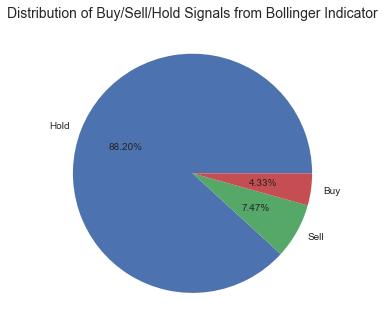

In [175]:
#Distrubition of the Indicator
labels = ["Hold", "Sell", "Buy"]
values = dataset['Bollinger Indicator'].value_counts().tolist()
plt.style.use("seaborn")
plt.pie(x=values, labels=labels, autopct="%1.2f%%")
plt.title("Distribution of Buy/Sell/Hold Signals from Bollinger Indicator", fontdict={'fontsize': 14})
plt.show()

Moving Average Convergence Divergence

In [176]:
# Calculating the MACD Line and the Signal Line
ema12 = dataset['Close'].ewm(span=12, adjust=False).mean()
ema26 = dataset['Close'].ewm(span=26, adjust=False).mean()
macd = ema12 - ema26
signal = macd.ewm(span=9, adjust=False).mean()


#Appeding the MACD and Signal Data to Dataset
dataset['MACD'] = macd
dataset['Signal'] = signal


In [177]:
# Adding Buy/Sell Signals from MACD
signal = []

for i in range(len(dataset)):
   if dataset['MACD'][i] > dataset['Signal'][i] and dataset['MACD'][i-1] < dataset['Signal'][i-1]:
      signal.append('Buy')
   elif dataset['MACD'][i] < dataset['Signal'][i] and dataset['MACD'][i-1] > dataset['Signal'][i-1]:
      signal.append('Sell')
   else:
      signal.append('Hold')

  
    
dataset['MACD Indicator'] = signal

In [178]:
# Distrubition of the Indicator
print(dataset['MACD Indicator'].value_counts())

Hold    2342
Buy       87
Sell      87
Name: MACD Indicator, dtype: int64


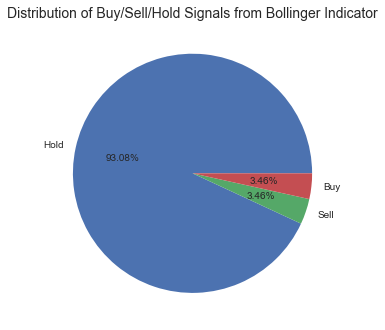

In [179]:
#Distrubition of the Indicator
labels = ["Hold", "Sell", "Buy"]
values = dataset['MACD Indicator'].value_counts().tolist()
plt.style.use("seaborn")
plt.pie(x=values, labels=labels, autopct="%1.2f%%")
plt.title("Distribution of Buy/Sell/Hold Signals from Bollinger Indicator", fontdict={'fontsize': 14})
plt.show()

Addding Target Variable

In [180]:
# Recommender Based on the three indicators
def recommender(row): 
    # If All Share the Same Signal OutPut That Signal (Buy)
    if row['RSI Indicator'] == "Buy" and row['SO Indicator'] == 'Buy' and  row['Bollinger Indicator'] == 'Buy':
        return 'Buy'
     # If Any 2 Indicators Share the Same Signal Output That Signal (buy)
    elif row['RSI Indicator'] == 'Buy' and row['SO Indicator'] == 'Buy':
        return 'Buy'
    elif row['RSI Indicator'] == 'Buy' and row['Bollinger Indicator'] == 'Buy':
        return 'Buy'
    elif row['SO Indicator'] == 'Buy' and row['Bollinger Indicator'] == 'Buy':
        return 'Buy'   
    # If All Share the Same Signal Output That Signal (Sell)
    elif row['RSI Indicator'] == 'Sell' and row['SO Indicator'] == 'Sell' and  row['Bollinger Indicator'] == 'Sell':
        return 'Sell'
    # If Any 2 Indicators Share the Same Signal Output That Signal (Sell)
    elif row['RSI Indicator'] == 'Sell' and row['SO Indicator'] == 'Sell':
        return 'Sell'
    elif row['RSI Indicator'] == 'Sell' and row['Bollinger Indicator'] == 'Sell':
        return 'Sell'
    elif row['SO Indicator'] == 'Sell' and row['Bollinger Indicator'] == 'Sell':
        return 'Sell'    
    # If All Share the Same Signal OutPut That Signal (Hold)
    elif row['RSI Indicator'] == 'Hold' and row['SO Indicator'] == 'Hold' and  row['Bollinger Indicator'] == 'Hold':
        return 'Hold'
    # If Any 2 Indicators Share the Same Signal Output That Signal (Hold)
    elif row['RSI Indicator'] == 'Hold' and row['SO Indicator'] == 'Hold':
        return 'Hold'
    elif row['RSI Indicator'] == 'Hold' and row['Bollinger Indicator'] == 'Hold':
        return 'Hold'
    elif row['SO Indicator'] == 'Hold' and row['Bollinger Indicator'] == 'Hold':
        return 'Hold'      
    else:
        return 'Unclassed'

dataset['Recommender'] = dataset.apply(lambda row: recommender(row), axis=1)

In [181]:
# Distrubition of the Recommender
print(dataset['Recommender'].value_counts())

Hold    2015
Sell     389
Buy      112
Name: Recommender, dtype: int64


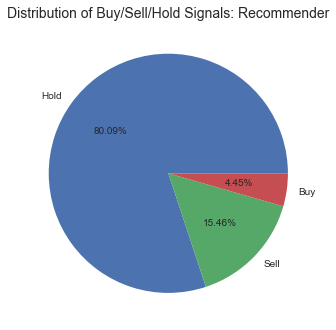

In [182]:
#Distrubition of the Recommender
labels = ["Hold", "Sell", "Buy"]
values = dataset['Recommender'].value_counts().tolist()
plt.style.use("seaborn")
plt.pie(x=values, labels=labels, autopct="%1.2f%%")
plt.title("Distribution of Buy/Sell/Hold Signals: Recommender", fontdict={'fontsize': 14})
plt.show()

Data Cleaning and Preprocessing

In [183]:
#Dataset shape after adding all the technical indicators 
dataset.shape

(2516, 17)

In [184]:
#Information regarding the dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2012-04-26 to 2022-04-25
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Open                 2516 non-null   float64
 1   Close                2516 non-null   float64
 2   High                 2516 non-null   float64
 3   Low                  2516 non-null   float64
 4   Volume               2516 non-null   int64  
 5   %K                   2503 non-null   float64
 6   %D                   2501 non-null   float64
 7   SO Indicator         2516 non-null   object 
 8   RSI                  2515 non-null   float64
 9   RSI Indicator        2516 non-null   object 
 10  Bollinger_Upper      2497 non-null   float64
 11  Bollinger_Lower      2497 non-null   float64
 12  Bollinger Indicator  2516 non-null   object 
 13  MACD                 2516 non-null   float64
 14  Signal               2516 non-null   float64
 15  MACD Indicator      

In [185]:
#Checking for Null Values
dataset.isna().sum()

Open                    0
Close                   0
High                    0
Low                     0
Volume                  0
%K                     13
%D                     15
SO Indicator            0
RSI                     1
RSI Indicator           0
Bollinger_Upper        19
Bollinger_Lower        19
Bollinger Indicator     0
MACD                    0
Signal                  0
MACD Indicator          0
Recommender             0
dtype: int64

In [186]:
#Dropping Null Values
dataset = dataset.dropna()
dataset.isna().sum()

Open                   0
Close                  0
High                   0
Low                    0
Volume                 0
%K                     0
%D                     0
SO Indicator           0
RSI                    0
RSI Indicator          0
Bollinger_Upper        0
Bollinger_Lower        0
Bollinger Indicator    0
MACD                   0
Signal                 0
MACD Indicator         0
Recommender            0
dtype: int64

In [187]:
#let's check if there is any duplicate data
print(dataset.duplicated().any())
print(dataset.duplicated().sum())

False
0


In [188]:
#Dataframe shape after dopping null values
dataset.shape

(2497, 17)

In [189]:
#Encode Categorical Variables
signal_dict = {'Hold': 0, 'Sell':1, 'Buy': 2}
dataset['SO Indicator'] = dataset['SO Indicator'].map(signal_dict)
dataset['RSI Indicator'] = dataset['RSI Indicator'].map(signal_dict)
dataset['Bollinger Indicator'] = dataset['Bollinger Indicator'].map(signal_dict)
dataset['MACD Indicator'] = dataset['MACD Indicator'].map(signal_dict)
#Target Variable
dataset['Recommender'] = dataset['Recommender'].map(signal_dict)

dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2497 entries, 2012-05-23 to 2022-04-25
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Open                 2497 non-null   float64
 1   Close                2497 non-null   float64
 2   High                 2497 non-null   float64
 3   Low                  2497 non-null   float64
 4   Volume               2497 non-null   int64  
 5   %K                   2497 non-null   float64
 6   %D                   2497 non-null   float64
 7   SO Indicator         2497 non-null   int64  
 8   RSI                  2497 non-null   float64
 9   RSI Indicator        2497 non-null   int64  
 10  Bollinger_Upper      2497 non-null   float64
 11  Bollinger_Lower      2497 non-null   float64
 12  Bollinger Indicator  2497 non-null   int64  
 13  MACD                 2497 non-null   float64
 14  Signal               2497 non-null   float64
 15  MACD Indicator      

In [190]:
dataset.tail()

,Open,Close,High,Low,Volume,%K,%D,SO Indicator,RSI,RSI Indicator,Bollinger_Upper,Bollinger_Lower,Bollinger Indicator,MACD,Signal,MACD Indicator,Recommender
Date,,,,,,,,,,,,,,,,,
2022-04-19,165.020004,167.399994,167.820007,163.910004,67723800,23.877732,11.648403,0,47.682943,0,180.626370,163.193633,0,-0.052764,1.014087,0,0
2022-04-20,168.759995,167.229996,168.880005,166.100006,67929800,24.530756,19.253371,0,47.438378,0,180.693310,162.967692,0,-0.182637,0.774742,0,0
2022-04-21,168.910004,166.419998,171.529999,165.910004,87227800,19.101818,22.503435,0,46.221902,0,180.806599,162.475402,0,-0.346923,0.550409,0,0
2022-04-22,166.460007,161.789993,167.869995,161.500000,84775200,1.706846,15.113140,2,39.920315,0,181.107113,160.946886,0,-0.841028,0.272122,0,0
2022-04-25,161.119995,162.880005,163.169998,158.460007,92824080,22.278221,14.362295,0,41.927588,0,180.981810,159.888189,0,-1.131611,-0.008625,0,0


In [191]:
#Splitting the dataset into training and test sets
#Feature Scaling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from imblearn.over_sampling import SMOTE

#Independant and Dependent Variable
y = dataset["Recommender"] #Dependent variable
x = dataset.drop(["Recommender"], axis=1) #Independent variable

#Splitting Data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, random_state= 0)
print("x_train dataset: ", x_train.shape)
print(" y_train dataset: ", y_train.shape)
print(" x_test dataset: ", x_test.shape)
print("y_test dataset: ", y_test.shape)

#Scaling
sscaler = StandardScaler()
x_train = sscaler.fit_transform(x_train)
x_test = sscaler.transform(x_test)

x_train dataset:  (1997, 16)
 y_train dataset:  (1997,)
 x_test dataset:  (500, 16)
y_test dataset:  (500,)


Text(0.5, 0, 'Signals')

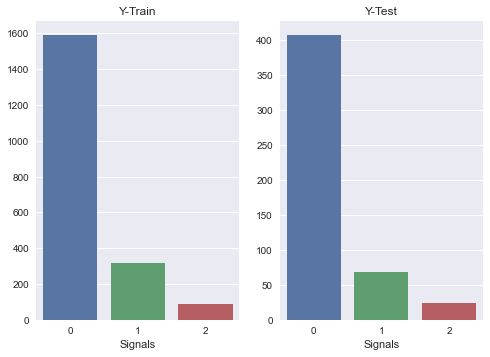

In [193]:
#Handling Imbalance datausing SMOTE
#Synthetic Minority Oversampling Technique
#Stroke (Dependant Variable) before SMOTE
fig, (ax1, ax2) = plt.subplots(1, 2)
sns.barplot(x=['0', '1','2'], y =[sum(y_train == 0), sum(y_train == 1), sum(y_train == 2)], ax = ax1)
ax1.set_title("Y-Train")
ax1.set_xlabel('Signals')

sns.barplot(x=['0', '1', '2'], y =[sum(y_test == 0), sum(y_test == 1), sum(y_test == 2)], ax = ax2)
ax2.set_title("Y-Test")
ax2.set_xlabel('Signals')

Text(0.5, 0, 'Signals')

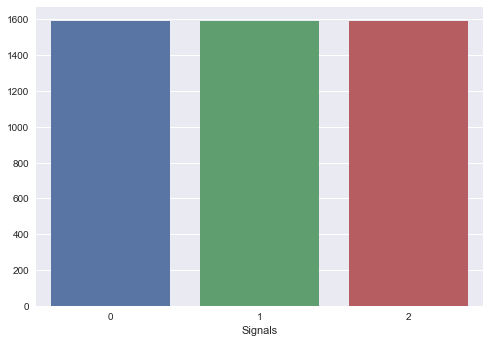

In [194]:
#Handling Imbalance datausing SMOTE
#Synthetic Minority Oversampling Technique
#Stroke (Dependant Variable) After SMOTE
sm = SMOTE(random_state=2)
x_train_res, y_train_res = sm.fit_resample(x_train, y_train.ravel())

fig = sns.barplot(x=['0', '1', '2'], y =[sum(y_train_res == 0), sum(y_train_res == 1), sum(y_train_res == 2)])
fig.set_xlabel('Signals')